### Imports

In [34]:
from ma_v04 import MA_PARTY
import supersuit as ss
from stable_baselines3 import PPO, A2C, DQN
import time
import csv
import pandas as pd

# Helper classes
import track_time
import analyse

In [35]:
# Track CPU/RAM
import threading
import psutil
import time
from datetime import datetime

def display_cpu():
    global running
    global cpu_total
    global ram_total
    global start_time

    running = True
    cpu_total = 0
    ram_total = 0
    start_time = time.strftime('%H%M%S')

    # start loop
    while running:
        "CPU-Auslastung oder -Nutzung bezeichnet die Zeit, die ein Computer benötigt, um bestimmte Informationen zu verarbeiten."
        cpu_temp = psutil.cpu_percent(interval=1)
        # print('Die CPU-Auslastung beträgt:', cpu_temp)
        cpu_total += cpu_temp

        "RAM-Auslastung oder HAUPTSPEICHER-AUSLASTUNG bezeichnet dagegen die Zeit, die RAM von einem bestimmten System zu einem bestimmten Zeitpunkt genutzt wird."
        ram_temp = psutil.virtual_memory()[2]
        # print('RAM memory % used:', ram_temp)
        ram_total += ram_temp

def start():
    global t

    # create thread and start it
    t = threading.Thread(target=display_cpu)
    t.start()
    
def stop():
    global running
    global end_time
    global t

    end_time = time.strftime('%H%M%S')

    # use `running` to stop loop in thread so thread will end
    running = False

    # wait for thread's end
    t.join()

    print("############################################")
    print("############################################")
    print("############################################")
    print("############################################")
    cpu_temp = round(cpu_total, 2)
    ram_temp = round(ram_total, 2)
    print(f"cpu_total: {cpu_temp}")
    print(f"ram_total: {ram_temp}")

    t1 = datetime.strptime(start_time, '%H%M%S')
    t2 = datetime.strptime(end_time, '%H%M%S')
    duration = t2 - t1
    seconds = duration.total_seconds()

    if seconds > 0:
        cpu_usage = round(cpu_total / seconds, 2)
        ram_usage = round(ram_total / seconds, 2)
        ram = round(ram_usage / 100 * 32, 2)

        print(f"cpu: {cpu_usage}\nram: {ram_usage} % {ram} GB\ntime: {seconds} seconds")

### Train MARL Model

In [33]:
def train(env_fn, steps: int = 10_000, seed: int = 0, **env_kwargs):
    env = env_fn(**env_kwargs)
    
    # env = parallel_to_aec(env)
    # parallel_env = parallel_wrapper_fn(env)

    print(f"Preparing training on {str(env.metadata['name'])}.")

    # env = ss.black_death_v3(env)
    
    obs, _ = env.reset(seed)
    
    # env = ss.agent_indicator_v0(env)
    env = ss.pettingzoo_env_to_vec_env_v1(env)
    
    model = PPO( # A2C( # DQN( # 
        "MlpPolicy",
        env,
        verbose=3,
        tensorboard_log="./ppo_ma_a2c_party_tensorboard/",
    )
    
    model.learn(total_timesteps=steps)
    model_name = f"./ma_models/{env.unwrapped.metadata.get('name')}_Rats_{time.strftime('%Y%m%d-%H%M%S')}"
    model.save(model_name)

    print("Model has been saved.")
    print(f"Finished training on {str(env.unwrapped.metadata['name'])}.")
    print(model_name)

    env.close()
    
model_name = None
start()
train(env_fn=MA_PARTY, steps=100_000)
stop()

Preparing training on marl_heroes_vs_goblins_v01.
Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Logging to ./ppo_ma_a2c_party_tensorboard/PPO_1
-----------------------------
| time/              |      |
|    fps             | 809  |
|    iterations      | 1    |
|    time_elapsed    | 2    |
|    total_timesteps | 2048 |
-----------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 596         |
|    iterations           | 2           |
|    time_elapsed         | 6           |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.005777807 |
|    clip_fraction        | 0.0365      |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.19       |
|    explained_variance   | -0.00505    |
|    learning_rate        | 0.0003      |
|    loss                 | 158         |
|    n_upd

### Test MARL MODEL

In [ ]:
model = PPO.load("ma_models\marl_heroes_vs_goblins_v01_a2c_20240804-214011")
env = MA_PARTY(render_mode="human") # , debug_mode=True)

episode_data = []
step_data = []
episodes = 100000

for episode in range(1, episodes):
    print(episode)
    
    observations, infos = env.reset()
    while env.agents:
        actions = {agent: model.predict(observations[agent])[0].item() for agent in env.agents}       
        # actions = {agent: env.action_space(agent).sample(infos[agent]["action_mask"]) for agent in env.agents} # action_mask
        # actions = {agent: env.action_space(agent).sample() for agent in env.agents} # random

        observations, rewards, terminations, truncations, infos = env.step(actions)
        
        step_data.append({"rogue": actions["rogue"], "fighter": actions["fighter"], "wizard": actions["wizard"], "cleric": actions["cleric"]})

    episode_data.append({"episode": episode, "reward": rewards["rogue"]})
    env.close()

# write reward per episode data
with open('data/marl_dqn.csv', 'w', newline='') as csvfile:
    fieldnames = ['episode', 'reward']
    writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
    writer.writeheader()
    writer.writerows(episode_data)

# write action per step data
with open('data/marl_dqn_actions.csv', 'w', newline='') as csvfile:
    fieldnames = ['rogue', 'fighter', 'wizard', 'cleric']
    writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
    writer.writeheader()
    writer.writerows(step_data)

# 174 min 1_000
# 193 min 10_000
# 22 min 100_000

### Analyse the data

In [36]:
# Load the data from the CSV file
data = pd.read_csv('data/marl_orcs2.csv')

# Analyse the data
analyse.analyze_data(data)

############### RESULTS ###############
Mean: 79.3
Q1: 60.0
Median: 100.0
Q3: 100.0
Min: -100
Max: 100
IQR (Interquartile Range): 40.0

All heroes survive: 66.9 %
3 heroes survive: 23.13 %
2 heroes survive: 5.05 %
1 heroes survive: 1.03 %
Heroes die: 3.51 %
Heros run away: 0.38 %


In [39]:
# Load the data from the CSV file
data = pd.read_csv('data/marl_100_000.csv')
# Analyse the data
analyse.analyze_data(data)

############### RESULTS ###############
Mean: 88.5
Q1: 100.0
Median: 100.0
Q3: 100.0
Min: -100
Max: 100
IQR (Interquartile Range): 0.0

All heroes survive: 82.26 %
3 heroes survive: 12.73 %
2 heroes survive: 2.28 %
1 heroes survive: 0.27 %
Heroes die: 2.27 %
Heros run away: 0.19 %


In [56]:
# Load the data from the CSV file
data = pd.read_csv('data/no_agent.csv')
# Analyse the data
analyse.analyze_data(data)

############### RESULTS ###############
Mean: 56.07
Q1: -50.0
Median: 100.0
Q3: 100.0
Min: -100
Max: 100
IQR (Interquartile Range): 150.0

All heroes survive: 63.54 %
3 heroes survive: 9.12 %
2 heroes survive: 0.82 %
1 heroes survive: 0.03 %
Heroes die: 0.08 %
Heros run away: 26.41 %


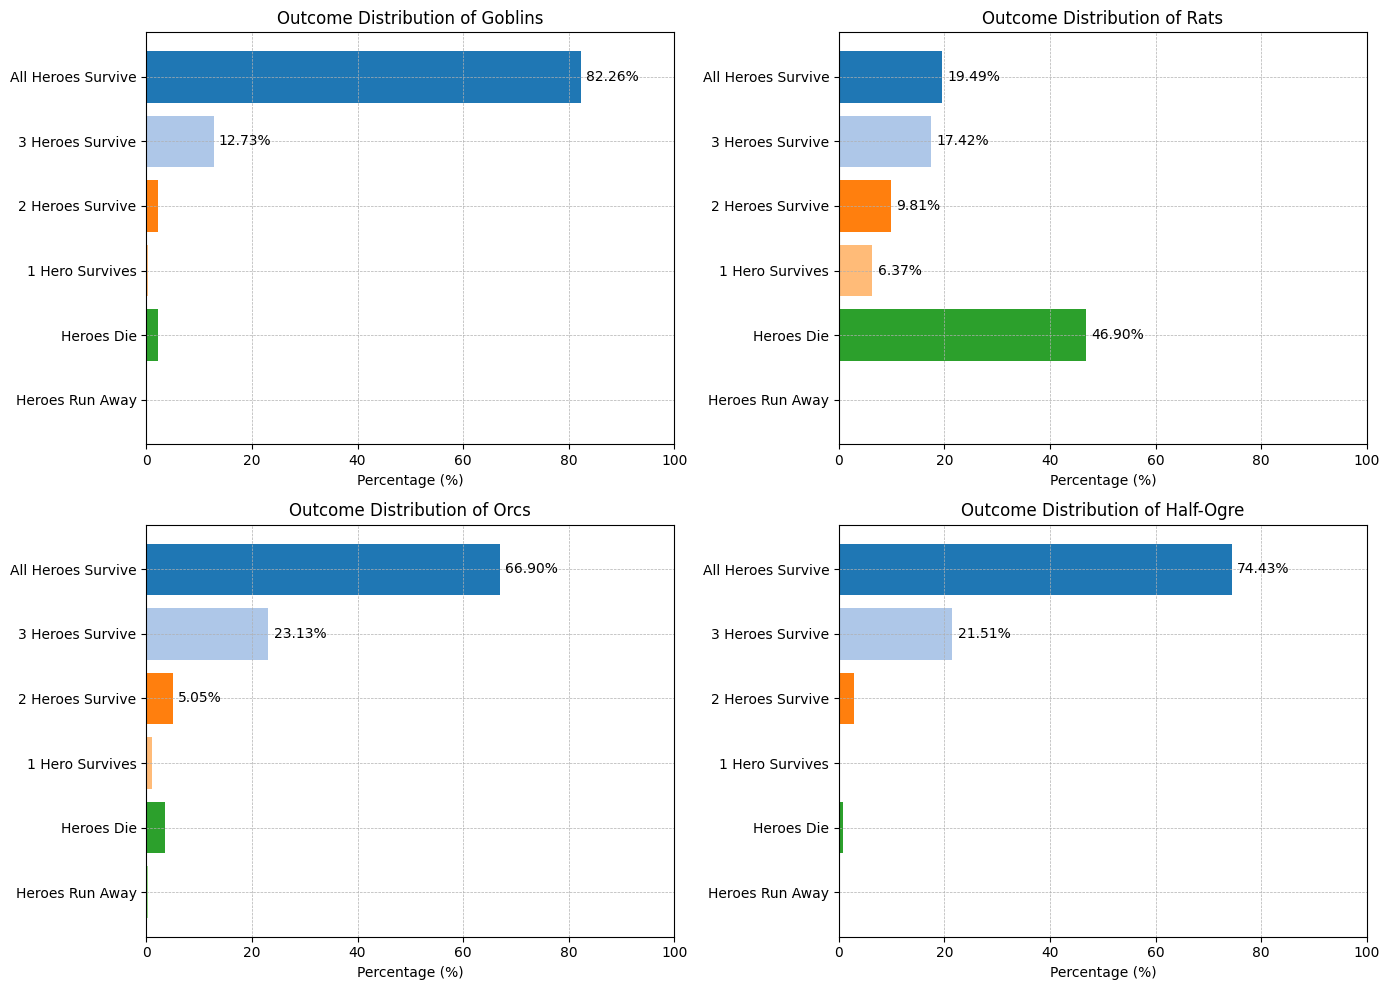

In [54]:
import pandas as pd
import matplotlib.pyplot as plt

# Read CSV data for different steps
data_100 = pd.read_csv('data/marl_100.csv')
data_1000 = pd.read_csv('data/marl_1_000.csv')
data_10000 = pd.read_csv('data/marl_10_000.csv')
data_100000 = pd.read_csv('data/marl_100_000.csv')

# Load the data for each class
data_10000 = pd.read_csv('data/marl_orcs2.csv')
data_100 = pd.read_csv('data/marl_100_000.csv')
data_1000 = pd.read_csv('data/marl_rats.csv')
data_100000 = pd.read_csv('data/marl_ogre.csv')

# Function to calculate outcome percentages
def calculate_outcomes(data):
    success_rate = round((data['reward'] == 100).sum() / data.shape[0] * 100, 2)
    three_heroes = round((data['reward'] == 60).sum() / data.shape[0] * 100, 2)
    two_heroes = round((data['reward'] == 40).sum() / data.shape[0] * 100, 2)
    one_hero = round((data['reward'] == 20).sum() / data.shape[0] * 100, 2)
    failure_rate = round((data['reward'] == -100).sum() / data.shape[0] * 100, 2)
    run_away_rate = round((data['reward'] == -50).sum() / data.shape[0] * 100, 2)
    return [success_rate, three_heroes, two_heroes, one_hero, failure_rate, run_away_rate]

# Calculate outcomes for each dataset
outcomes_100 = calculate_outcomes(data_100)
outcomes_1000 = calculate_outcomes(data_1000)
outcomes_10000 = calculate_outcomes(data_10000)
outcomes_100000 = calculate_outcomes(data_100000)

# Combine data into a dictionary
data = {
    "Goblins": outcomes_100,
    "Rats": outcomes_1000,
    "Orcs": outcomes_10000,
    "Half-Ogre": outcomes_100000
}

# List of outcomes corresponding to the calculated values
outcomes = [
    "All Heroes Survive", "3 Heroes Survive", "2 Heroes Survive",
    "1 Hero Survives", "Heroes Die", "Heroes Run Away"
]

# Create a 2x2 grid of bar plots
fig, axs = plt.subplots(2, 2, figsize=(14, 10))

# Flatten the axes array for easy iteration
axs = axs.flatten()

# Define colors for the bars
colors = plt.cm.tab20.colors

# Loop through each step count and create a bar plot
for i, (steps, percentages) in enumerate(data.items()):
    ax = axs[i]
    ax.barh(outcomes, percentages, color=colors[:len(outcomes)])
    ax.set_title(f"Outcome Distribution of {steps}")
    ax.set_xlim(0, 100)  # Set x-axis limit to 100% for consistency
    ax.set_xlabel("Percentage (%)")
    ax.invert_yaxis()  # Invert y-axis for better readability
    ax.grid(True, which='both', linestyle='--', linewidth=0.5)
    
    # Display percentage labels on the bars
    for j, percentage in enumerate(percentages):
        if percentage > 5:  # Only add label if space permits (e.g., > 5%)
            ax.text(percentage + 1, j, f'{percentage:.2f}%', va='center')

# Adjust layout to prevent overlap
plt.tight_layout()

# Show plot
plt.show()


C:\Users\cehmaxim19\AppData\Local\Temp\ipykernel_11148\4223088812.py:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Step Count', y='reward', data=combined_df, palette="Set2")


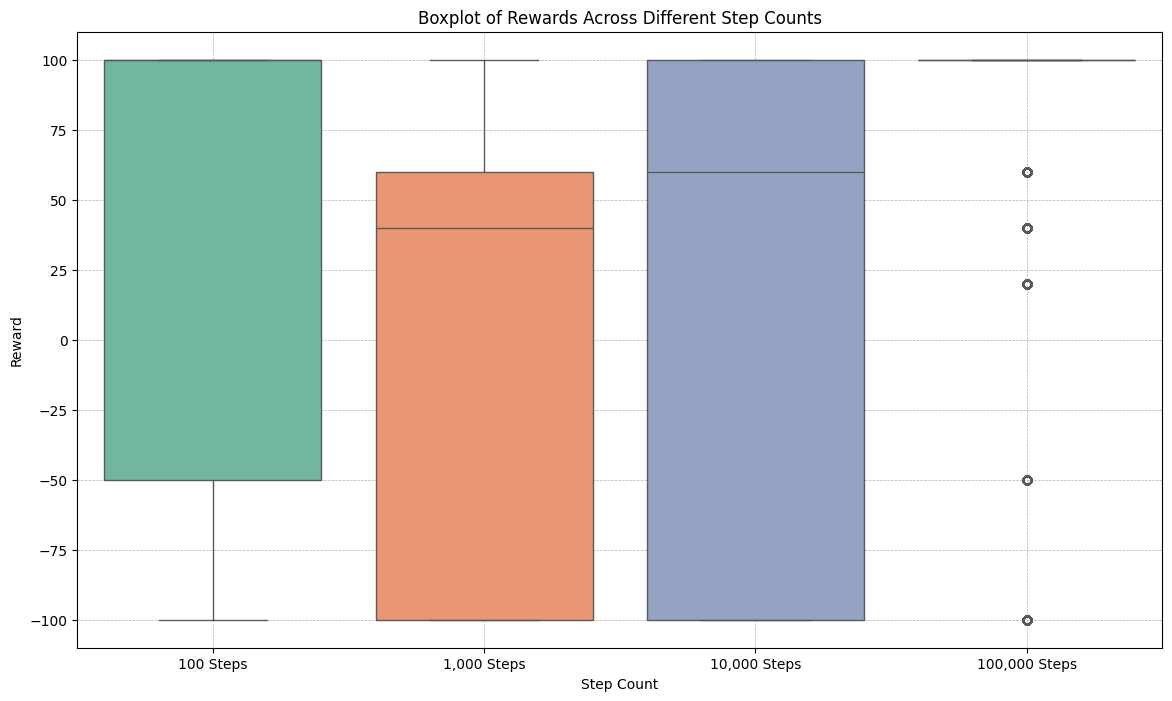

In [55]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Define file paths (replace with your actual file paths)
files = {
    '100 Steps': 'data/no_agent.csv',
    '1,000 Steps': 'data/sarl_1_000.csv',
    '10,000 Steps': 'data/sarl_10_000.csv',
    '100,000 Steps': 'data/sarl_100_000.csv'
}

# Read the data and append step count information
dataframes = []
for label, file_path in files.items():
    df = pd.read_csv(file_path)
    df['Step Count'] = label
    dataframes.append(df)

# Concatenate all DataFrames
combined_df = pd.concat(dataframes, ignore_index=True)

# Create the boxplot
plt.figure(figsize=(14, 8))
sns.boxplot(x='Step Count', y='reward', data=combined_df, palette="Set2")
plt.title('Boxplot of Rewards Across Different Step Counts')
plt.xlabel('Step Count')
plt.ylabel('Reward')
plt.grid(True, linestyle='--', linewidth=0.5)
plt.show()

C:\Users\cehmaxim19\AppData\Local\Temp\ipykernel_11148\524051290.py:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Step Count', y='reward', data=combined_df, palette="Set2")


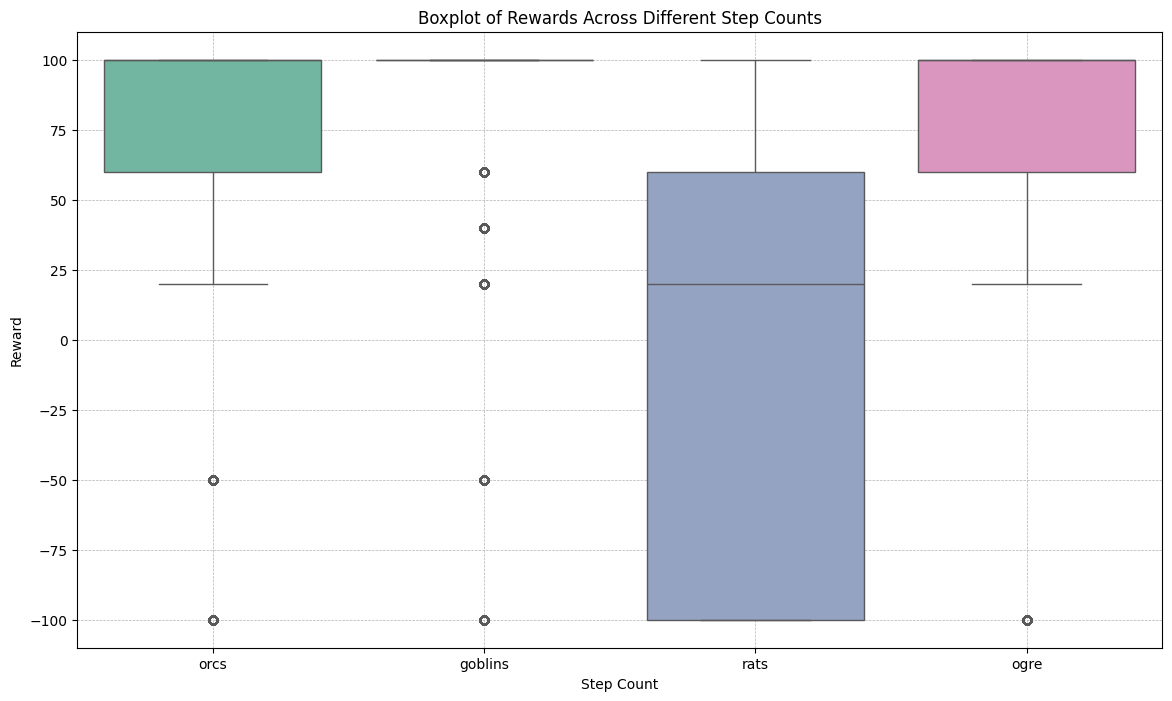

In [62]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Define file paths (replace with your actual file paths)
files = {
    "orcs": 'data/marl_orcs2.csv',
    "goblins": 'data/marl_100_000.csv',
    "rats": 'data/marl_rats.csv',
    "ogre": 'data/marl_ogre.csv'
}

# Read the data and append step count information
dataframes = []
for label, file_path in files.items():
    df = pd.read_csv(file_path)
    df['Step Count'] = label
    dataframes.append(df)

# Concatenate all DataFrames
combined_df = pd.concat(dataframes, ignore_index=True)

# Create the boxplot
plt.figure(figsize=(14, 8))
sns.boxplot(x='Step Count', y='reward', data=combined_df, palette="Set2")
plt.title('Boxplot of Rewards Across Different Step Counts')
plt.xlabel('Step Count')
plt.ylabel('Reward')
plt.grid(True, linestyle='--', linewidth=0.5)
plt.show()

### Action Spread Chart

In [8]:
# Load the data
data = pd.read_csv('data/marl_10_000_actions.csv')

# Analyse the data
analyse.analyze_action_spread(data)


rogue:
Counts:
  Action 0: 371751
  Action 1: 892021
  Action 2: 943178
  Action 3: 774523
  Action 4: 199008
  Action 5: 307287
  Action 6: 499587
  Action 7: 304509
  Action 8: 225435
Frequencies (%):
  Action 0: 8.23%
  Action 1: 19.75%
  Action 2: 20.88%
  Action 3: 17.15%
  Action 4: 4.41%
  Action 5: 6.80%
  Action 6: 11.06%
  Action 7: 6.74%
  Action 8: 4.99%

fighter:
Counts:
  Action 0: 371447
  Action 1: 892961
  Action 2: 943052
  Action 3: 772241
  Action 4: 199902
  Action 5: 306621
  Action 6: 500960
  Action 7: 303366
  Action 8: 226749
Frequencies (%):
  Action 0: 8.22%
  Action 1: 19.77%
  Action 2: 20.88%
  Action 3: 17.10%
  Action 4: 4.43%
  Action 5: 6.79%
  Action 6: 11.09%
  Action 7: 6.72%
  Action 8: 5.02%

wizard:
Counts:
  Action 0: 372291
  Action 1: 891654
  Action 2: 944124
  Action 3: 773108
  Action 4: 198978
  Action 5: 306918
  Action 6: 500591
  Action 7: 303230
  Action 8: 226405
Frequencies (%):
  Action 0: 8.24%
  Action 1: 19.74%
  Action 2: 20.9

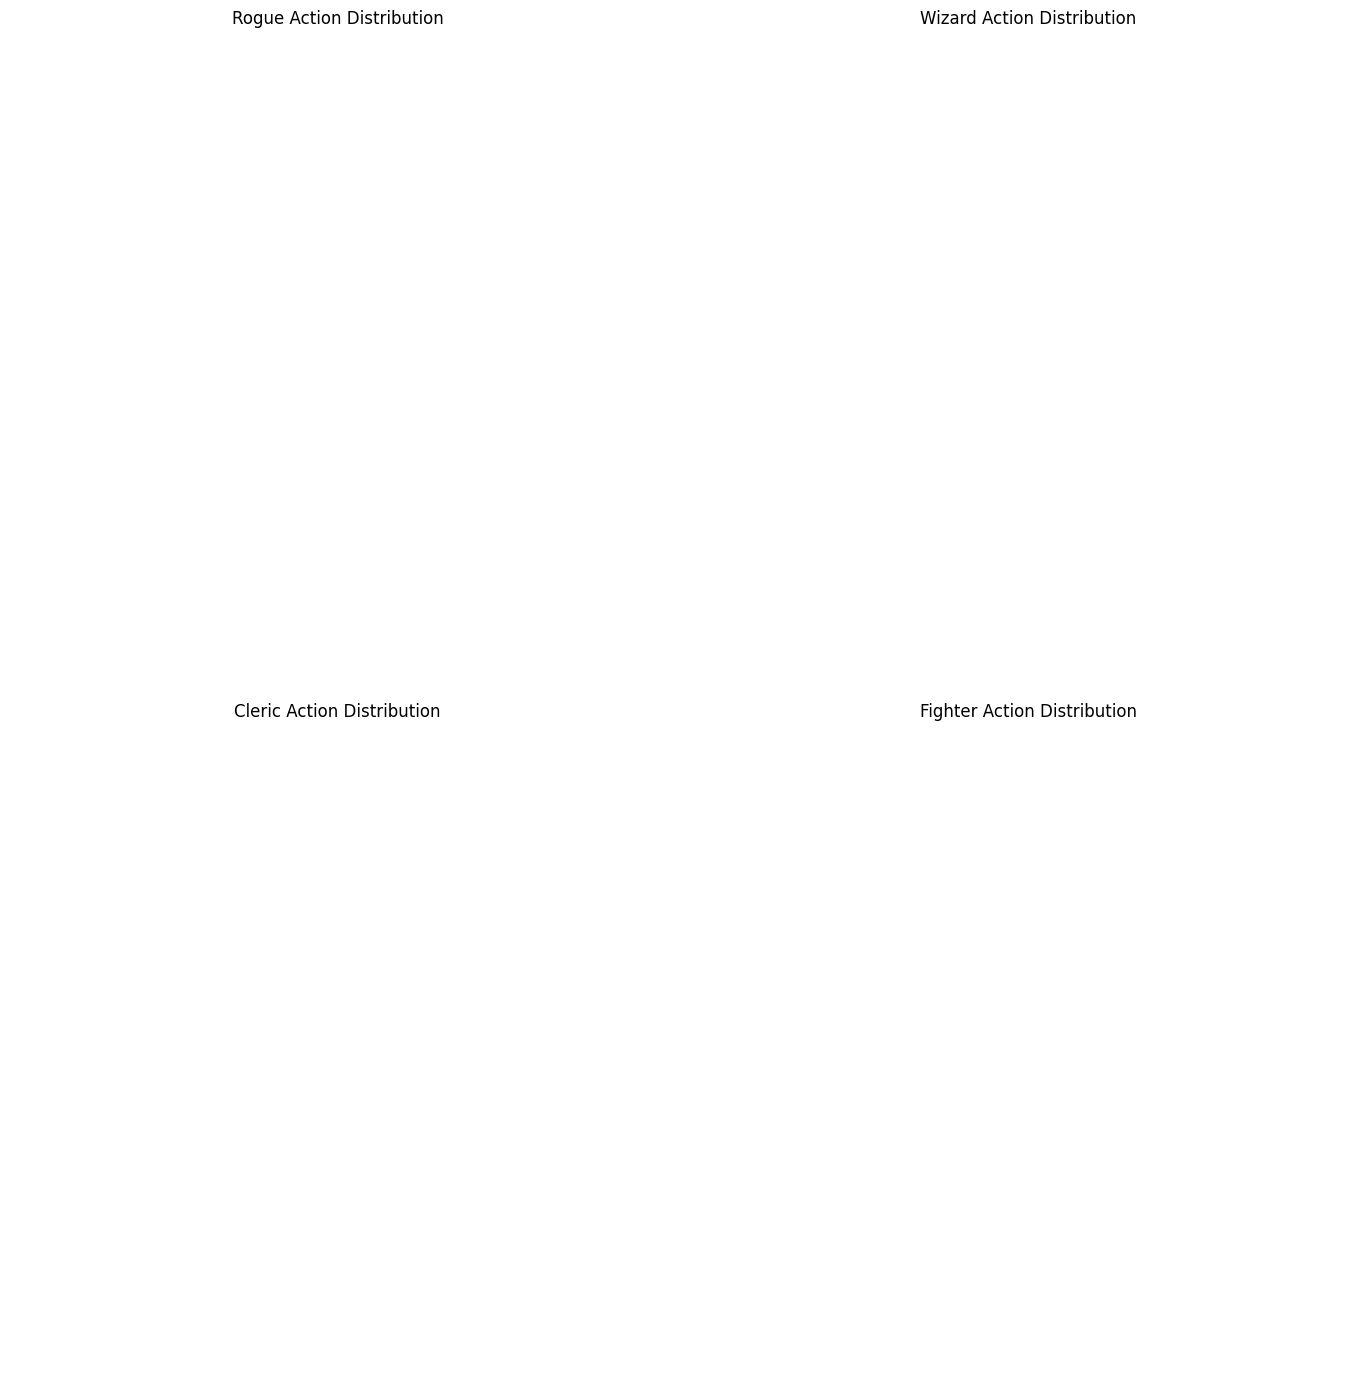

In [63]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np

# Load the data
data = pd.read_csv('data/no_agent_actions.csv')

# Function to calculate counts
def calculate_counts(column):
    return column.value_counts().sort_index()

# Calculate action counts for each class
class_names = ['rogue', 'wizard', 'cleric', 'fighter']
class_counts = {name: calculate_counts(data[name]) for name in class_names}

# Normalize data for pie charts
normalized_counts = {name: counts / counts.sum() for name, counts in class_counts.items()}

# Creating color scale
cmap = plt.get_cmap("tab20c")
colors = cmap(np.arange(len(class_counts['rogue'])))

# Function to filter labels and percentages based on a threshold
def filter_labels_and_percentages(counts, threshold=0.05):
    total = counts.sum()
    labels = []
    pct_labels = []
    for i, count in enumerate(counts):
        if count / total >= threshold:
            labels.append(f'Action {i}')
            pct_labels.append(f'{count / total:.1%}')
        else:
            labels.append('')  # Empty label for small slices
            pct_labels.append('')  # Empty percentage for small slices
    return labels, pct_labels

# Custom autopct function
def make_autopct(pct_labels):
    def autopct(pct):
        return pct_labels.pop(0)
    return autopct

# Creating the figure and axes for a 2x2 grid of plots
fig, axs = plt.subplots(2, 2, figsize=(14, 14))

# Plot pie charts for each class
for ax, class_name in zip(axs.flatten(), class_names):
    counts = class_counts[class_name]
    norm = normalized_counts[class_name]
    labels, pct_labels = filter_labels_and_percentages(counts)
    
    ax.pie(norm, labels=labels, colors=colors,
           autopct=make_autopct(pct_labels), startangle=140)
    ax.set_title(f"{class_name.capitalize()} Action Distribution")

# Adjust layout for better spacing
plt.tight_layout()

# Show plot
plt.show()


In [66]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np

# Load the data for each class
orc_data = pd.read_csv('data/sarl_nobuffer_actions.csv')
goblin_data = pd.read_csv('data/sarl_100_000_actions.csv')
rat_data = pd.read_csv('data/marl_100_000_actions.csv')
ogre_data = pd.read_csv('data/marl_100_000_actions.csv')

# Extract just the "rogue" column for each dataset
orc_rogue = orc_data
goblin_rogue = goblin_data
rat_rogue = rat_data['wizard']
ogre_rogue = ogre_data['wizard']

# Function to calculate counts
def calculate_counts(column):
    return column.value_counts().sort_index()

# Calculate action counts for the "rogue" column in each dataset
orc_counts = calculate_counts(orc_rogue)
goblin_counts = calculate_counts(goblin_rogue)
rat_counts = calculate_counts(rat_rogue)
ogre_counts = calculate_counts(ogre_rogue)

# Normalize data for pie charts
orc_normalized = orc_counts / orc_counts.sum()
goblin_normalized = goblin_counts / goblin_counts.sum()
rat_normalized = rat_counts / rat_counts.sum()
ogre_normalized = ogre_counts / ogre_counts.sum()

# Creating color scale
cmap = plt.get_cmap("tab20c")
colors = cmap(np.arange(len(orc_counts)))

# Function to filter labels and percentages based on a threshold
def filter_labels_and_percentages(counts, threshold=0.05):
    total = counts.sum()
    labels = []
    pct_labels = []
    for i, count in enumerate(counts):
        if count / total >= threshold:
            labels.append(f'Action {i}')
            pct_labels.append(f'{count / total:.1%}')
        else:
            labels.append('')  # Empty label for small slices
            pct_labels.append('')  # Empty percentage for small slices
    return labels, pct_labels

# Custom autopct function
def make_autopct(pct_labels):
    def autopct(pct):
        return pct_labels.pop(0)
    return autopct

# Creating the figure and axes for a 2x2 grid of plots
fig, axs = plt.subplots(2, 2, figsize=(14, 14))

# Plot pie charts for each dataset
for ax, (counts, norm, title) in zip(axs.flatten(), 
                                     [(orc_counts, orc_normalized, "Action Distribution 100 steps"),
                                      (goblin_counts, goblin_normalized, "Action Distribution 1_000 steps"),
                                      (rat_counts, rat_normalized, "Action Distribution 10_000 steps"),
                                      (ogre_counts, ogre_normalized, "Action Distribution 100_000 steps")]):
    labels, pct_labels = filter_labels_and_percentages(counts)
    
    ax.pie(norm, labels=labels, colors=colors,
           autopct=make_autopct(pct_labels), startangle=140)
    ax.set_title(title)

# Adjust layout for better spacing
plt.tight_layout()

# Show plot
plt.show()


KeyboardInterrupt: 

Error in callback <function flush_figures at 0x00000251AE0C49D0> (for post_execute), with arguments args (),kwargs {}:


KeyboardInterrupt: 

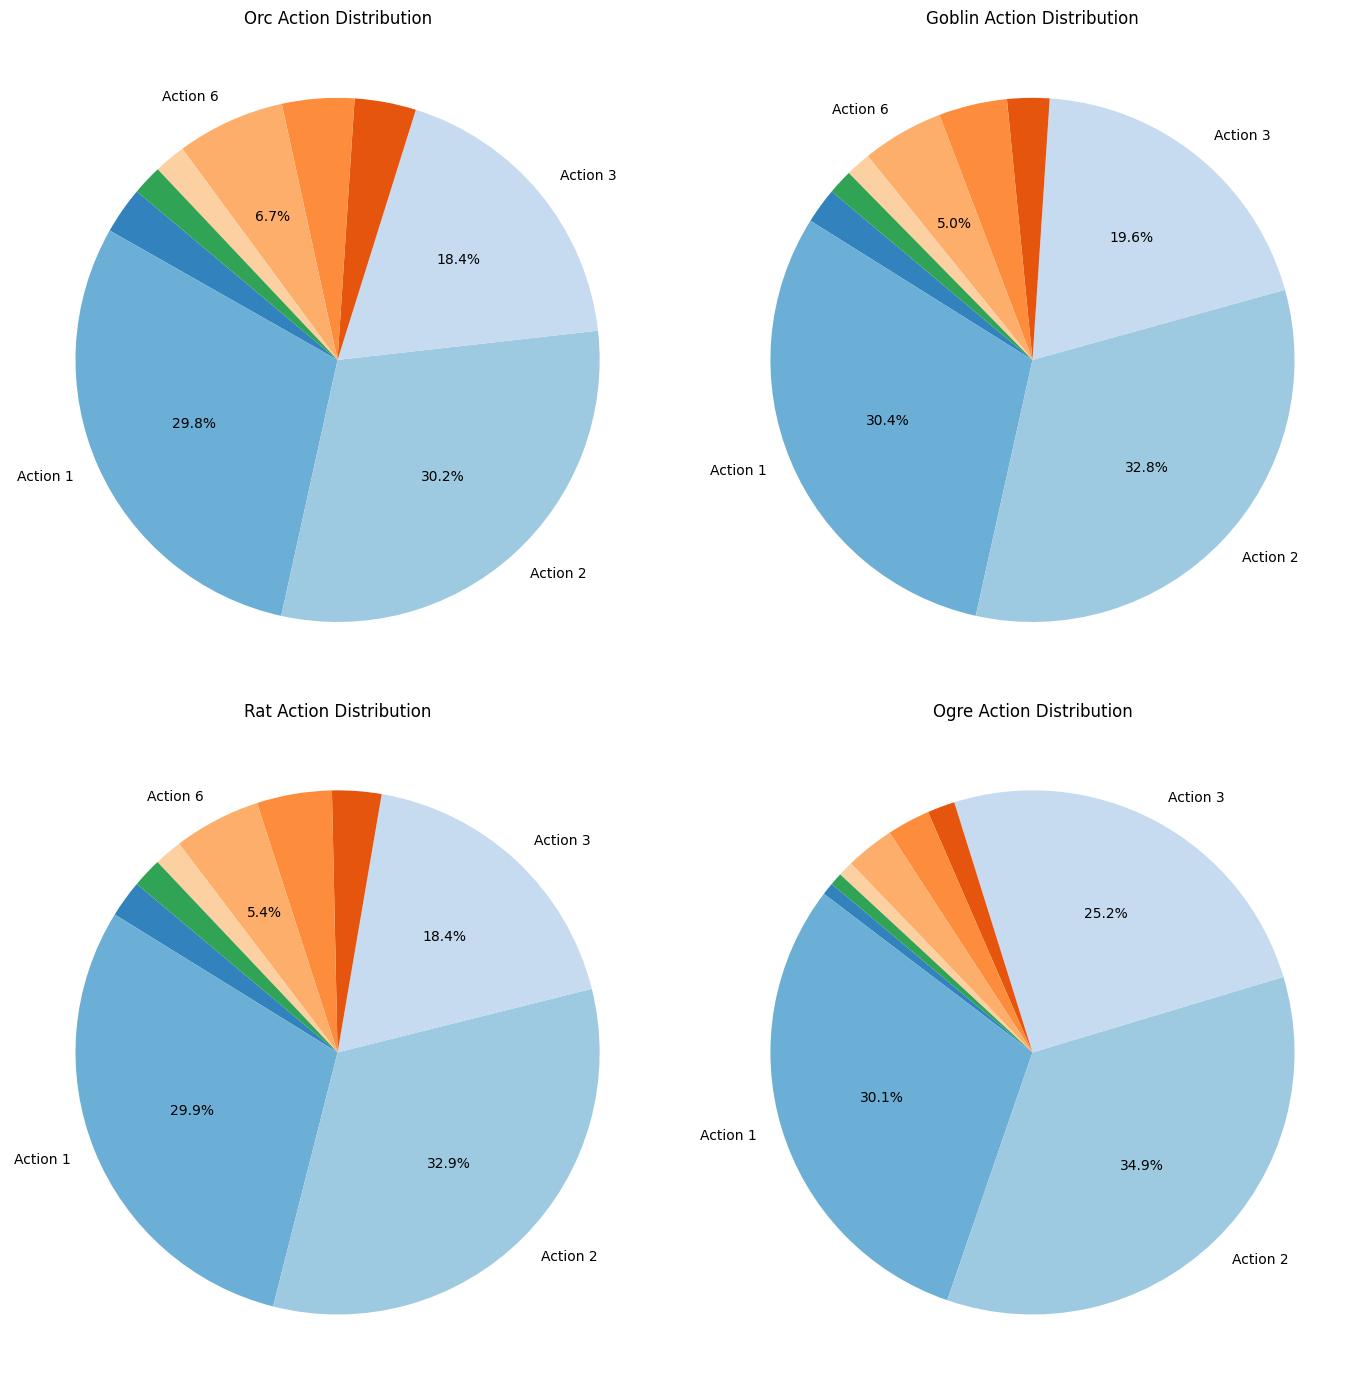

In [64]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np

# Load the data for each class
orc_data = pd.read_csv('data/sarl_orcs_actions.csv')
goblin_data = pd.read_csv('data/sarl_100_000_actions.csv')
rat_data = pd.read_csv('data/sarl_rats_actions.csv')
ogre_data = pd.read_csv('data/sarl_ogre_actions.csv')

# Function to calculate counts across all columns
def calculate_counts_all_columns(df):
    counts = df.apply(pd.Series.value_counts).sum(axis=1).sort_index()
    return counts

# Calculate action counts for all columns in each dataset
orc_counts = calculate_counts_all_columns(orc_data)
goblin_counts = calculate_counts_all_columns(goblin_data)
rat_counts = calculate_counts_all_columns(rat_data)
ogre_counts = calculate_counts_all_columns(ogre_data)

# Normalize data for pie charts
orc_normalized = orc_counts / orc_counts.sum()
goblin_normalized = goblin_counts / goblin_counts.sum()
rat_normalized = rat_counts / rat_counts.sum()
ogre_normalized = ogre_counts / ogre_counts.sum()

# Creating color scale
cmap = plt.get_cmap("tab20c")
colors = cmap(np.arange(len(orc_counts)))

# Function to filter labels and percentages based on a threshold
def filter_labels_and_percentages(counts, threshold=0.05):
    total = counts.sum()
    labels = []
    pct_labels = []
    for i, count in enumerate(counts):
        if count / total >= threshold:
            labels.append(f'Action {i}')
            pct_labels.append(f'{count / total:.1%}')
        else:
            labels.append('')  # Empty label for small slices
            pct_labels.append('')  # Empty percentage for small slices
    return labels, pct_labels

# Custom autopct function
def make_autopct(pct_labels):
    def autopct(pct):
        return pct_labels.pop(0)
    return autopct

# Creating the figure and axes for a 2x2 grid of plots
fig, axs = plt.subplots(2, 2, figsize=(14, 14))

# Plot pie charts for each dataset
for ax, (counts, norm, title) in zip(axs.flatten(), 
                                     [(orc_counts, orc_normalized, "Orc Action Distribution"),
                                      (goblin_counts, goblin_normalized, "Goblin Action Distribution"),
                                      (rat_counts, rat_normalized, "Rat Action Distribution"),
                                      (ogre_counts, ogre_normalized, "Ogre Action Distribution")]):
    labels, pct_labels = filter_labels_and_percentages(counts)
    
    ax.pie(norm, labels=labels, colors=colors,
           autopct=make_autopct(pct_labels), startangle=140)
    ax.set_title(title)

# Adjust layout for better spacing
plt.tight_layout()

# Show plot
plt.show()


In [49]:
import pandas as pd

# Load the data for each dataset
actions_100 = pd.read_csv('data/marl_100_actions.csv')
actions_1k = pd.read_csv('data/marl_1_000_actions.csv')
actions_10k = pd.read_csv('data/marl_10_000_actions.csv')
actions_100k = pd.read_csv('data/marl_100_000_actions.csv')

# Function to calculate the action spread across all columns
def calculate_action_spread(df):
    spread = df.apply(pd.Series.value_counts).sum(axis=1).sort_index()
    return spread

# Calculate action spread for each dataset
spread_100 = calculate_action_spread(actions_100)
spread_1k = calculate_action_spread(actions_1k)
spread_10k = calculate_action_spread(actions_10k)
spread_100k = calculate_action_spread(actions_100k)

# Combine spreads into a single DataFrame for easy comparison
action_spread_table = pd.DataFrame({
    '100 Actions': spread_100,
    '1,000 Actions': spread_1k,
    '10,000 Actions': spread_10k,
    '100,000 Actions': spread_100k
})

# Fill NaN values with 0 (in case some actions are missing in a dataset)
action_spread_table = action_spread_table.fillna(0).astype(int)

# Display the table
print(action_spread_table)


   100 Actions  1,000 Actions  10,000 Actions  100,000 Actions
0      2018581        2083024         1481856            44791
1      1981367        2098193         3548436            71728
2      1926513        2019269         3757735          1808858
3      2029231        2072893         3075851            28246
4      1435429        1523170          794005             9977
5      1770791        1607137         1226189            17665
6      1636763        1605686         1997929            13874
7      1479399        1738398         1207033            12220
8      1478410        1531586          900102             8685
